<a href="https://colab.research.google.com/github/KhamessiTaha/CarVisionProject/blob/main/Car_Model_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile


train_zip_path = '/content/drive/MyDrive/batch_one/batch_one_train.zip'


extracted_train_folder = '/content/drive/MyDrive/batch_one/train'


with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_train_folder)

print("Training data extraction completed.")


In [ ]:

test_zip_path = '/content/drive/MyDrive/batch_one/batch_one_test.zip'


extracted_test_folder = '/content/drive/MyDrive/batch_one/test'


with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_test_folder)

print("Testing data extraction completed.")



Testing data extraction completed.


In [ ]:
%cd /content/drive/MyDrive/batch_one/
!ls

/content/drive/MyDrive/batch_one
batch_one_test.zip  batch_one_train.zip  model_checkpoint_best.h5  model_checkpoint.h5	test  train


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

In [ ]:
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/batch_one/')
print(data_dir)

/content/drive/MyDrive/batch_one


/content/drive/MyDrive/batch_one/train/images/946467.jpg


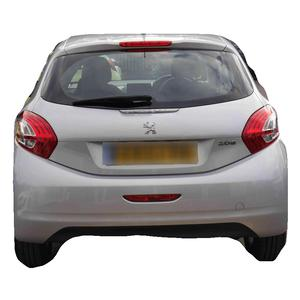

In [39]:
cars_train = list(data_dir.glob('train/images/*'))
print(cars_train[0])
PIL.Image.open(str(cars_train[0]))

/content/drive/MyDrive/batch_one/test/images/73055.jpg


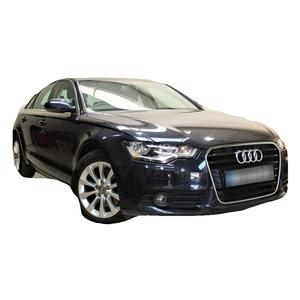

In [9]:
cars_test = list(data_dir.glob('test/images/*'))
print(cars_test[0])
PIL.Image.open(str(cars_test[3]))

In [10]:


train_labels_df = pd.read_csv('/content/drive/MyDrive/batch_one/train/train_labels.csv')
test_labels_df = pd.read_csv('/content/drive/MyDrive/batch_one/test/test_labels.csv')


train_labels_df['Year'] = train_labels_df['Year'].astype(str)
test_labels_df['Year'] = test_labels_df['Year'].astype(str)


train_labels_df['Brand'] = train_labels_df[['Make', 'Model', 'Year']].apply(lambda x: '_'.join(x), axis=1)
test_labels_df['Brand'] = test_labels_df[['Make', 'Model', 'Year']].apply(lambda x: '_'.join(x), axis=1)


train_labels_df.drop(columns=['Make', 'Model', 'Year'], inplace=True)
test_labels_df.drop(columns=['Make', 'Model', 'Year'], inplace=True)


print("Train Labels DataFrame:")
print(train_labels_df.head())
print("\nTest Labels DataFrame:")
print(test_labels_df.head())

Train Labels DataFrame:
         Image                Brand
0  1247261.jpg  Vauxhall_Corsa_2008
1   462484.jpg       Ford_Kuga_2013
2  1042043.jpg  Renault_Kadjar_2017
3   322720.jpg        Fiat_500_2008
4   949692.jpg     Peugeot_207_2008

Test Labels DataFrame:
       Image         Brand
0  14729.jpg  Audi_A1_2019
1  15731.jpg  Audi_A1_2019
2  15940.jpg  Audi_A1_2019
3  15823.jpg  Audi_A1_2019
4  15439.jpg  Audi_A1_2019


In [11]:
img_height,img_width=300,300
batch_size=32
train_aug = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    height_shift_range=0.1,
    width_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    zoom_range = [1, 1.5],
    fill_mode='nearest'
)
test_aug = ImageDataGenerator(rescale=1./255)



In [12]:

col ="Brand"

train_generator = train_aug.flow_from_dataframe(
    dataframe=train_labels_df,
    directory='train/images',
    x_col='Image',
    y_col=col,
    target_size=(img_height,img_width),
    seed=42,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 32000 validated image filenames belonging to 200 classes.


In [13]:


test_generator = test_aug.flow_from_dataframe(
    dataframe=test_labels_df,
    directory='test/images',
    x_col='Image',
    y_col=col,
    target_size=(img_height,img_width),
    seed=42,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 7229 validated image filenames belonging to 200 classes.


In [14]:
class_names = train_labels_df['Brand'].unique()
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(class_names)


Number of classes: 200
['Vauxhall_Corsa_2008' 'Ford_Kuga_2013' 'Renault_Kadjar_2017'
 'Fiat_500_2008' 'Peugeot_207_2008' 'Vauxhall_Mokka_2015'
 'Ford_Focus_2008' 'SEAT_Ibiza_2011' 'Honda_CR-V_2012'
 'Vauxhall_Astra_2006' 'Land Rover_Range Rover_2015' 'Ford_Focus_2015'
 'BMW_X5_2016' 'Ford_Fiesta_2005' 'Vauxhall_Insignia_2011' 'BMW_X5_2005'
 'Ford_Kuga_2014' 'Jaguar_X-Type_2009' 'Nissan_Qashqai_2015'
 'Vauxhall_Mokka_2014' 'Ford_Mondeo_2011' 'Ford_Fiesta_2017'
 'Toyota_Auris_2015' 'Vauxhall_Corsa_2018' 'Ford_Focus_2010'
 'Vauxhall_Insignia_2015' 'Vauxhall_Corsa_2016' 'Jaguar_XF_2014'
 'Nissan_Qashqai_2012' 'Renault_Clio_2010' 'Vauxhall_Zafira Tourer_2017'
 'Vauxhall_Astra_2015' 'Vauxhall_Corsa_2012' 'Volkswagen_Golf_2017'
 'Jaguar_XF_2012' 'Audi_A3_2005' 'Audi_A4_2012' 'Fiat_Punto Evo_2010'
 'Ford_Ka_2015' 'BMW_1 Series_2019' 'BMW_X5_2007' 'Citroen_DS3_2014'
 'BMW_X5_2010' 'Volkswagen_Passat_2015' 'Ford_Ka_2010'
 'Volkswagen_Polo_2006' 'Ford_Ka_2009' 'Citroen_C3_2019'
 'Mazda_Mazda3_201

In [15]:
import matplotlib.pyplot as plt




#Training The Model

In [18]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50V2(
                   include_top=False,
                   input_shape=(300,300,3),
                   pooling='avg',
                   classes=200,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(200, activation='softmax'))

94668760/94668760 [==============================] - 3s 0us/step


In [19]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 module_wrapper (ModuleWrap  (None, 2048)              0         
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 512)               1049088   
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 200)               102600    
 apper)                                                          
                                                                 
Total params: 24716488 (94.29 MB)
Trainable params: 1151688 (4.39 MB)
Non-trainable params: 23564800 (89.89 MB)
__________

In [ ]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
from keras.callbacks import ModelCheckpoint
checkpoint_filepath = '/content/drive/MyDrive/batch_one/model_checkpoint.h5'
best_checkpoint_filepath = '/content/drive/MyDrive/batch_one/model_checkpoint_best.h5'

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=True,
                                      save_freq=100)

best_checkpoint_callback = ModelCheckpoint(filepath=best_checkpoint_filepath,
                                           save_weights_only=True,
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [25]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = resnet_model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=5,
                    validation_data=test_generator,
                    validation_steps=len(test_generator),
                    callbacks=[checkpoint_callback, best_checkpoint_callback])

Epoch 1/5
1000/1000 [==============================] - 18799s 19s/step - loss: 2.6527 - accuracy: 0.3064 - val_loss: 2.8574 - val_accuracy: 0.2631
Epoch 2/5
1000/1000 [==============================] - 3237s 3s/step - loss: 2.5610 - accuracy: 0.3213 - val_loss: 2.8338 - val_accuracy: 0.2722
Epoch 3/5
1000/1000 [==============================] - 3260s 3s/step - loss: 2.4985 - accuracy: 0.3314 - val_loss: 2.8281 - val_accuracy: 0.2771
Epoch 4/5
1000/1000 [==============================] - 3262s 3s/step - loss: 2.4390 - accuracy: 0.3431 - val_loss: 2.7092 - val_accuracy: 0.2927
Epoch 5/5
1000/1000 [==============================] - 3233s 3s/step - loss: 2.3747 - accuracy: 0.3571 - val_loss: 2.7790 - val_accuracy: 0.2771


In [26]:
from keras.models import load_model

resnet_model.load_weights('/content/drive/MyDrive/batch_one/model_checkpoint.h5')


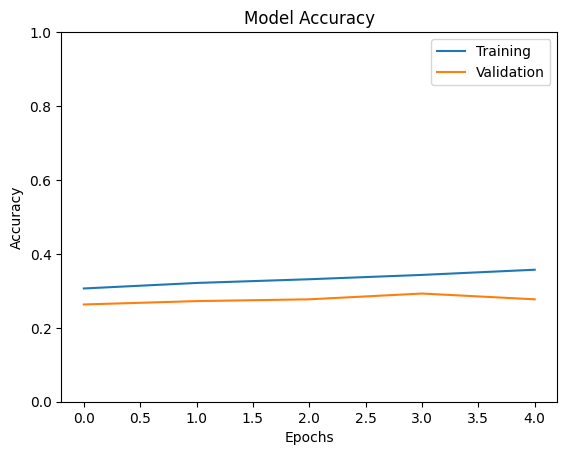

In [50]:
fig1 = plt.gcf()

if 'accuracy' in history.history and 'val_accuracy' in history.history:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])


    plt.ylim([0.0, 1.0])


    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')


    plt.legend(['Training', 'Validation'])


    plt.show()
else:
    print("No accuracy data found in history object.")


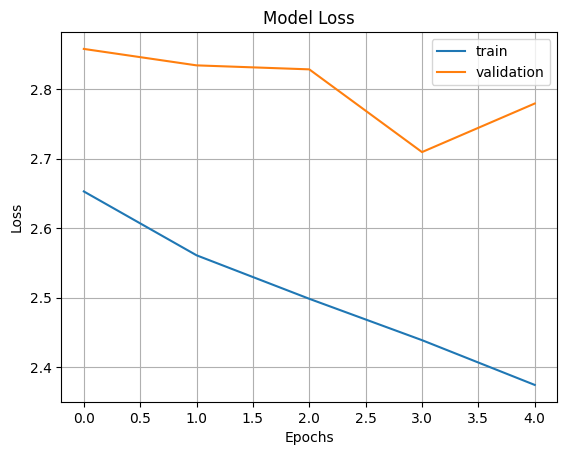

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#Making Predictions

In [47]:
import cv2
image=cv2.imread(str(cars_test[95]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

(1, 300, 300, 3)


In [48]:
pred=resnet_model.predict(image)
print(pred)

1/1 [==============================] - 0s 106ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]


In [49]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is Ford_Ka_2014
